## Verifying the performance of Cosine with filtered and unfiltered spectra


## Adjusted filtering for GC/MS

The filters applied in the previous noteboooks were design for the use of LC/MS, however, due to the lack of parent mass in GC/MS and the better resolution in the scan, the filtering has been changed in ordered to obtain more peaks from the sample

# Obtaining the data from the Mona File

## Getting the path for Mona file

Using the method load_from_msp, the information inside the Mona file is being obtained.

In [1]:
import os
import sys

ROOT = os.path.dirname(os.getcwd())
sys.path.insert(0, ROOT)

In [ ]:
from custom_functions.spectra_functions import get_data_folder_path

# from_external=False to use the data folder within the project
path = get_data_folder_path(from_external=False)
msp_file = os.path.join(path, "MoNA-export-GC-MS.msp")

## Appliying filters to the spectra

Applied filters are:
* normalize_intensities(s)
* reduce_to_number_of_peaks(s, **n_required=10**, **ratio_desired=0.5**)
* select_by_mz(s, **mz_from=0**, **mz_to=1000**)
* require_minimum_number_of_peaks(s, **n_required=10**)

In [2]:
from matchms.importing import load_from_msp

spectrums = [s for s in load_from_msp(msp_file)]
print("Number of Spectra:", len(spectrums))

Number of Spectra: 14847


In [3]:
spectrums = [s for s in spectrums if len(s.peaks.intensities) > 0]
print("Remaining Spectra:", len(spectrums))

Remaining Spectra: 14847


## Select a sample of one thousand pairs  of spectra

In [4]:
import numpy as np

def select_1000_spectra(data):

    reference_sample = np.random.choice(spectrums, 1000)
    query_sample = np.random.choice(spectrums, 1000)
    
    return [[reference_sample[i], query_sample[i]] for i in range(len(reference_sample))]
        
one_k_sample = select_1000_spectra(spectrums)

## Filters to apply to a subset of Spectra

Applied filters are:
* select_by_mz(s, **mz_from=0**, **mz_to=1000**)
* normalize_intensities(s)
* select_by_relative_intensity(s, **intensity_from=0.05**, **intensity_to=0.1**)

Trying filtering relative intensities from 0.05 to 1

In [5]:
from matchms.filtering import normalize_intensities
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity

def apply_my_filters(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = select_by_relative_intensity(s, intensity_from=0.05, intensity_to=1.0)
    return s

## Computing the Similarity score

The similarity algorithm used to test the new filtering is Cosine Greedy with NIST "powers", because it was observed in the previous notebook that its performance was most similar to spec2vec scores.

In [6]:
from datetime import datetime
from matchms import calculate_scores
from matchms.similarity import CosineGreedy
import numpy as np

def calculate_similarity_scores(spectrums, tolerance=0.1):
    
    similarity_measure = CosineGreedy(tolerance, 3.0, 0.6)
    similarity_scores, n_matches = [], []
    
    for s in spectrums:
        similarity_temp, n_matches_temp = similarity_measure(s[0], s[1])
        similarity_scores.append(similarity_temp)
        n_matches.append(n_matches_temp)
    
    return similarity_scores, n_matches

similarities_unfiltered, matches_unfiltered = calculate_similarity_scores(one_k_sample, 0.5)

## Filtering Spectra without peaks

Some Spectra does not have peaks and throw NaN with computing the similarity score, therefore they are filtered out

In [7]:
def filter_spectra(spectrums):
    temp_filtered = []
    for spectre in spectrums:
        temp_filtered.append([apply_my_filters(s) for s in spectre if len(s.peaks.intensities) > 0])
    return temp_filtered    
            
one_k_sample_filtered = filter_spectra(one_k_sample)

In [8]:

similarities_filtered, matches_filtered = calculate_similarity_scores(one_k_sample_filtered, 0.5)


/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/matchms-0.5.0-py3.7.egg/matchms/similarity/spectrum_similarity_functions.py:72: RuntimeWarning: invalid value encountered in double_scalars
  score = score/(numpy.sqrt(numpy.sum(spec1_power**2)) * numpy.sqrt(numpy.sum(spec2_power**2)))


## Displaying a mirror plot of scores of the filtered and unfiltered spectra 

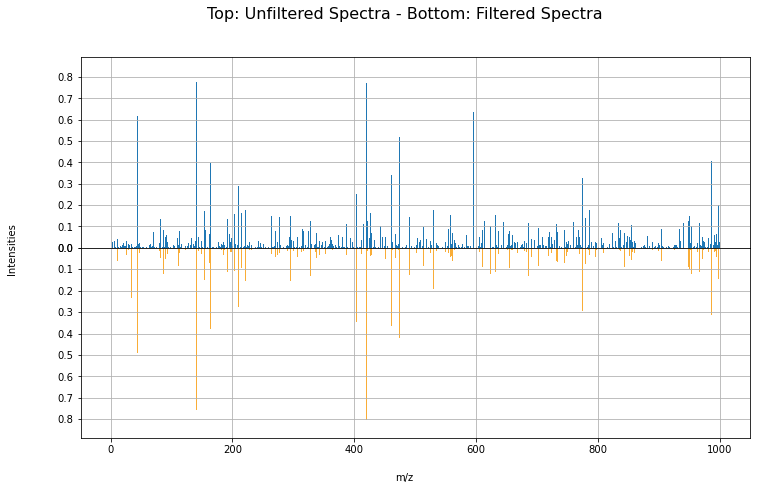

In [9]:
import matplotlib.pyplot as plt
    
def print_mirror_plot(similarities, similarities_filtered):
    size = np.arange(1, len(similarities)+1)
    
    fig, [ax1, ax2] = plt.subplots(2,1, figsize=(12,7))    
    fig.suptitle('Top: Unfiltered Spectra - Bottom: Filtered Spectra', fontsize=16)
    fig.text(0.5, 0.04, 'm/z', ha='center')
    fig.text(0.04, 0.5, 'Intensities', va='center', rotation='vertical')
    plt.subplots_adjust(hspace=0.0)
    ax1.bar(size, similarities)
    ax1.grid(True)
    ax2 = plt.subplot(212)
    plt.bar(size, similarities_filtered, color='#f9ad37') 
    ax2.set_ylim(ax2.get_ylim()[::-1])
    ax2.grid(True)
    plt.show()
    
print_mirror_plot(similarities_unfiltered, similarities_filtered)


## Histogram of similarity scores of filtered and unfiltered spectra

<Figure size 864x504 with 0 Axes>

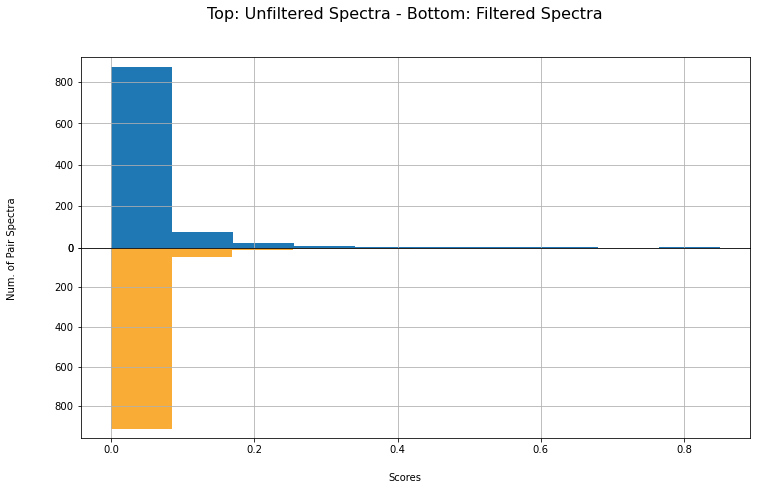

In [10]:
def plot_mirror_histogram(unfiltered, filtered):

    size = np.arange(1, len(unfiltered)+1)
    
    plt.figure(figsize=(12,7))
    fig, [ax1, ax2] = plt.subplots(2,1, sharex=True, figsize=(12,7))
    fig.suptitle('Top: Unfiltered Spectra - Bottom: Filtered Spectra', fontsize=16)
    fig.text(0.5, 0.04, 'Scores', ha='center')
    fig.text(0.04, 0.5, 'Num. of Pair Spectra', va='center', rotation='vertical')
    
    plt.subplots_adjust(hspace=0.0)
    ax1.hist(unfiltered)
    ax1.grid(True)
    
    ax2.hist(filtered, color='#f9ad37')
    ax2.set_ylim(ax2.get_ylim()[::-1])
    ax2.grid(True)
    
    plt.show()
    
plot_mirror_histogram(similarities_unfiltered, similarities_filtered)


## Selecting other one thousand random sample to compare the similarity scores

In [12]:
one_k_sample = select_1000_spectra(spectrums)
similarities_unfiltered, matches_unfiltered = calculate_similarity_scores(one_k_sample, 0.5)
one_k_sample_filtered = filter_spectra(one_k_sample)
similarities_filtered, matches_filtered = calculate_similarity_scores(one_k_sample_filtered, 0.5)

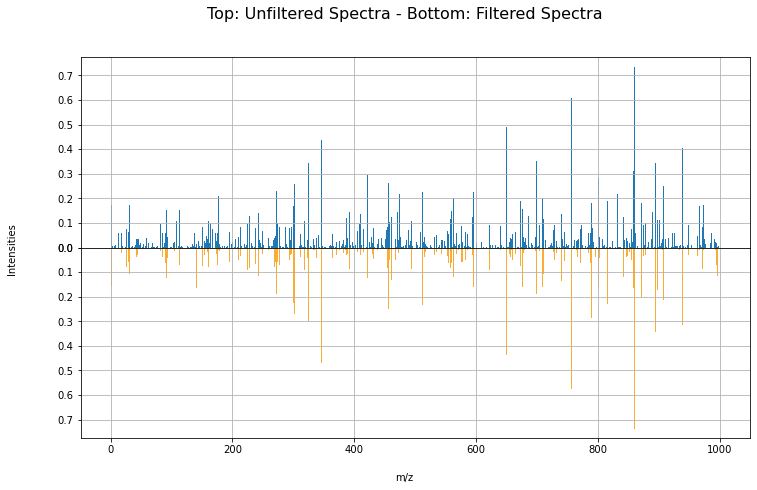

In [13]:
print_mirror_plot(similarities_unfiltered, similarities_filtered)

<Figure size 864x504 with 0 Axes>

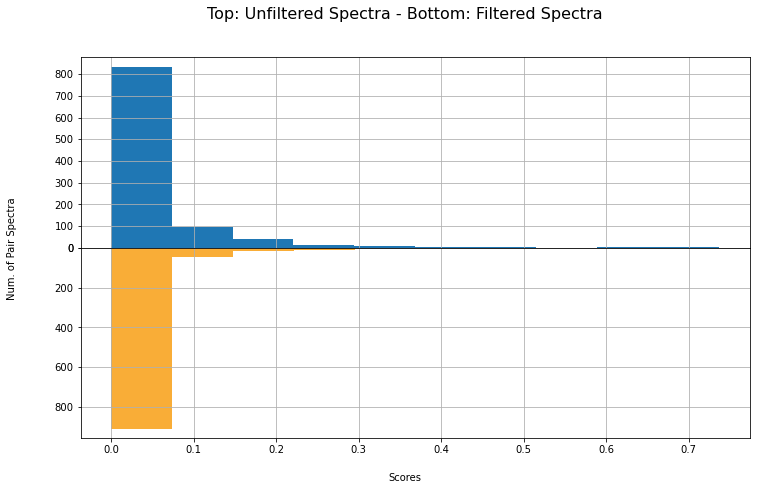

In [14]:
plot_mirror_histogram(similarities_unfiltered, similarities_filtered)